In [1]:
import json

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# from collections import defaultdict
# import os
# import sys
# 
# import tira.rest_api_client
# from tqdm import tqdm
# 
# tira_client = tira.rest_api_client.Client(failsave_retries=1, failsave_max_delay=1)
# task = 'generative-ai-authorship-verification-panclef-2024'
# 
# task_datasets = [d for d in tira_client.datasets(task).keys()
#                  if d != 'pan24-generative-authorship-news-check-20240523-test' and not d.endswith('-training')]
# 
# evaluations = []
# for d in tqdm(task_datasets, desc='Retrieving evaluations'):
#     e = tira_client.evaluations(task, d)
#     if e.empty:
#         continue
#     evaluations.append(e[['dataset', 'team', 'software']])
# evaluations = pd.concat(evaluations).dropna().drop_duplicates()
# 
# teams_to_softwares = defaultdict(set)
# for _, r in evaluations.iterrows():
#     teams_to_softwares[r['team']].add(str(r['software']))
# with open('teams-to-systems.json', 'w') as f: json.dump({k: sorted(v) for k, v in teams_to_softwares.items()}, f, ensure_ascii=False, indent=2)
# 
# 
# # Block verbose output
# tira.rest_api_client.tqdm = lambda *args, **_: args
# tira.rest_api_client.print = lambda *args: None
# try:
#     evaluation_scores = defaultdict(lambda: defaultdict(dict))
#     for _, r in tqdm(evaluations.iterrows(), desc='Downloading runs'):
#         dir = tira_client.download_evaluation(task, r['dataset'], r['software'], r['team'])
#         if not os.path.isfile(os.path.join(dir, 'evaluation.json')):
#             print(f'Failed to download {r["team"]}/{r["software"]}/{r["dataset"]}', file=sys.stderr)
#             continue
#         with open(os.path.join(dir, 'evaluation.json')) as f:
#             evaluation_scores[r['team']][r['software']][r['dataset']] = json.load(f)
#             
#     with open('evaluation-scores.json', 'w') as f: json.dump(evaluation_scores, f, ensure_ascii=False, indent=2)
# finally:
#     # Unscrew output muffler
#     tira.rest_api_client.tqdm = tqdm
#     del tira.rest_api_client.print

In [3]:
teams_to_systems = json.load(open('teams-to-systems.json'))
datasets = {
    # dataset_name: (category, prefix, suffix)
    'pan24-generative-authorship-test-20240502-test': ('main', '', ''),
    'pan24-generative-authorship-test-b-20240506-test': ('cross-domain', '', '-cross-domain'),
    'pan24-generative-authorship-news-test-c-20240506-test': ('unicode-full', '', '-unicode-full'),
    'pan24-generative-authorship-news-test-d-20240506-test': ('unicode-half', '', '-unicode-half'),
    # 'pan24-generative-authorship-news-test-e-20240506-test': ('german', '', '-german'),          # German was mixed into main dataset
    'pan24-generative-authorship-news-test-f-20240514-test': ('paraphrase', '', '-paraphrase'),
    'pan24-generative-authorship-news-test-g-20240529-test': ('contrastive', '', ''),              # suffix already part of the name
    'pan24-generative-authorship-news-test-h-20240521-test': ('short', '', '-short'),
    'pan24-generative-authorship-eloquent-20240523-test': ('eloquent', 'eloquent-', ''),
}

df_ = []
df_micro_mean_ = []
evaluation_scores = json.load(open('evaluation-scores.json', 'r'))
for team, systems in teams_to_systems.items():
    for s in systems:
        row_base = {'system': s, 'team': team if team != 'baseline' else s}
        for d, (dname, pre, suff) in datasets.items():
            df_micro_mean_.append({
                **row_base,
                'category': dname,
                **{k:v for k, v in evaluation_scores[team].get(s, {}).get(d, {}).items() if k != '_sources'}
            })
            df_.extend(
                {
                    **row_base,
                    'dataset': ''.join((pre, src, suff)),
                    'category': dname,
                    **evaluation_scores[team][s][d]['_sources'][src]
                } for src in evaluation_scores[team].get(s, {}).get(d, {}).get('_sources', [])
            )

df_micro_mean_ = pd.DataFrame(df_micro_mean_)#.fillna(0)
df_micro_mean_.set_index(['team', 'system', 'category'], inplace=True)

df_ = pd.DataFrame(df_)
df_.set_index(['team', 'system', 'category', 'dataset'], inplace=True)

### Micro Mean (All)

In [4]:
df_micro_mean_[df_micro_mean_.isna().any(axis=1)].reset_index()[['team', 'system', 'category']]

,team,system,category
0,baseline-detectgpt-falcon,baseline-detectgpt-falcon,cross-domain
1,baseline-detectgpt-falcon,baseline-detectgpt-falcon,unicode-full
2,baseline-detectgpt-falcon,baseline-detectgpt-falcon,unicode-half
3,baseline-detectgpt-falcon,baseline-detectgpt-falcon,paraphrase
4,baseline-detectgpt-falcon,baseline-detectgpt-falcon,contrastive
...,...,...,...
94,ds-gtpan,nervous-blur,cross-domain
95,ds-gtpan,nervous-blur,unicode-full
96,ds-gtpan,nervous-blur,unicode-half
97,ds-gtpan,nervous-blur,paraphrase


### Macro Mean (All)

In [5]:
df_

roc-auc  \
team                system              category dataset                                
baseline-binoculars baseline-binoculars main     alpaca-7b                      0.976   
                                                 bigscience-bloomz-7b1          0.993   
                                                 gemini-pro                     1.000   
                                                 gemini-pro-high-temperature    1.000   
                                                 gpt-3.5-turbo-0125             0.984   
...                                                                               ...   
ds-gtpan            nervous-blur        eloquent eloquent-chatgpt35             0.643   
                                                 eloquent-gptsw3                0.679   
                                                 eloquent-reindeer-mistral      0.818   
                                                 eloquent-reindeer-poro         0.792   
                                                 eloquent-verbanex-ai           0.664   

                                                                              brier  \
team                system              category dataset                              
baseline-binoculars baseline-binoculars main     alpaca-7b                    0.967   
                                                 bigscience-bloomz-7b1        0.967   
                                                 gemini-pro                   0.983   
                                                 gemini-pro-high-temperature  0.980   
                                                 gpt-3.5-turbo-0125           0.963   
...                                                                             ...   
ds-gtpan            nervous-blur        eloquent eloquent-chatgpt35           0.667   
                                                 eloquent-gptsw3              0.708   
                                                 eloquent-reindeer-mistral    0.833   
                                                 eloquent-reindeer-poro       0.792   
                                                 eloquent-verbanex-ai         0.625   

                                                                                c@1  \
team                system              category dataset                              
baseline-binoculars baseline-binoculars main     alpaca-7b                    0.979   
                                                 bigscience-bloomz-7b1        0.978   
                                                 gemini-pro                   1.000   
                                                 gemini-pro-high-temperature  0.996   
                                                 gpt-3.5-turbo-0125           0.974   
...                                                                             ...   
ds-gtpan            nervous-blur        eloquent eloquent-chatgpt35           0.667   
                                                 eloquent-gptsw3              0.708   
                                                 eloquent-reindeer-mistral    0.833   
                                                 eloquent-reindeer-poro       0.792   
                                                 eloquent-verbanex-ai         0.625   

                                                                                 f1  \
team                system              category dataset                              
baseline-binoculars baseline-binoculars main     alpaca-7b                    0.980   
                                                 bigscience-bloomz-7b1        0.973   
                                                 gemini-pro                   1.000   
                                                 gemini-pro-high-temperature  0.997   
                                                 gpt-3.5-turbo-0125           0.966   
...                                            

### Final System Selection (by Best Micro Mean Effectiveness on Main Dataset Category)

In [6]:
df_systems_final = df_micro_mean_.query('category == "main"').groupby('team')['mean'].idxmax().dropna()
df_systems_final = df_micro_mean_.loc[df_systems_final].sort_values('mean', ascending=False)
df_systems_final = df_systems_final.reset_index()[['team', 'system']]
df_systems_final.set_index(['team', 'system'], inplace=True)
df_systems_final

,
team,system
marsan,staff-trunk
iimasnlp,final-run4-gnnllm_llmft_stylofeat-partitionB
lam,blistering-moss
you-shun-you-de,charitable-mole_v3
jaha,greasy-chest
aida,corporate-burn
drocks,muffled-stock
logistic-fsu,logistic-fsu
verification-team,merciless-lease


### Dataframes Filtered

In [7]:
df = df_.loc[df_systems_final.index.get_level_values(0), df_systems_final.index.get_level_values(1), :]
df

roc-auc  brier  \
team        system      category dataset                                       
marsan      staff-trunk main     alpaca-7b                      1.000  0.995   
                                 bigscience-bloomz-7b1          1.000  0.993   
                                 gemini-pro                     1.000  0.999   
                                 gemini-pro-high-temperature    1.000  0.997   
                                 gpt-3.5-turbo-0125             1.000  0.997   
...                                                               ...    ...   
lm-detector detector    eloquent eloquent-chatgpt35             0.821  0.781   
                                 eloquent-gptsw3                0.539  0.615   
                                 eloquent-reindeer-mistral      0.594  0.677   
                                 eloquent-reindeer-poro         0.417  0.531   
                                 eloquent-verbanex-ai           0.600  0.677   

                                                                c@1     f1  \
team        system      category dataset                                     
marsan      staff-trunk main     alpaca-7b                    0.995  0.995   
                                 bigscience-bloomz-7b1        1.000  1.000   
                                 gemini-pro                   1.000  1.000   
                                 gemini-pro-high-temperature  0.996  0.997   
                                 gpt-3.5-turbo-0125           1.000  1.000   
...                                                             ...    ...   
lm-detector detector    eloquent eloquent-chatgpt35           0.688  0.762   
                                 eloquent-gptsw3              0.458  0.286   
                                 eloquent-reindeer-mistral    0.486  0.421   
                                 eloquent-reindeer-poro       0.344  0.211   
                                 eloquent-verbanex-ai         0.486  0.471   

                                                               f05u   mean  
team        system      category dataset                                    
marsan      staff-trunk main     alpaca-7b                    0.998  0.996  
                                 bigscience-bloomz-7b1        1.000  0.999  
                                 gemini-pro                   1.000  1.000  
                                 gemini-pro-high-temperature  0.999  0.998  
                                 gpt-3.5-turbo-0125           1.000  0.999  
...                                                             ...    ...  
lm-detector detector    eloquent eloquent-chatgpt35           0.656  0.742  
                                 eloquent-gptsw3              0.349  0.449  
                                 eloquent-reindeer-mistral    0.476  0.531  
                                 eloquent-reindeer-poro       0.233  0.347  
                                 eloquent-verbanex-ai         0.444  0.536  

[2876 rows x 6 columns]

In [8]:
df_micro_mean = df_micro_mean_.loc[df_systems_final.index.get_level_values(0), df_systems_final.index.get_level_values(1), :]
df_micro_mean

roc-auc  brier    c@1     f1   f05u  \
team        system      category                                            
marsan      staff-trunk main            1.000  0.995  0.997  0.997  0.999   
                        cross-domain    1.000  0.994  0.997  0.997  0.999   
                        unicode-full    0.998  0.971  0.978  0.979  0.989   
                        unicode-half    0.985  0.924  0.947  0.945  0.975   
                        paraphrase      0.999  0.977  0.994  0.994  0.998   
...                                       ...    ...    ...    ...    ...   
lm-detector detector    unicode-half    0.672  0.713  0.616  0.539  0.570   
                        paraphrase      0.510  0.651  0.343  0.302  0.324   
                        contrastive     0.533  0.598  0.491  0.433  0.441   
                        short           0.629  0.700  0.531  0.491  0.506   
                        eloquent        0.576  0.656  0.493  0.433  0.449   

                                       mean  
team        system      category             
marsan      staff-trunk main          0.998  
                        cross-domain  0.997  
                        unicode-full  0.983  
                        unicode-half  0.955  
                        paraphrase    0.993  
...                                     ...  
lm-detector detector    unicode-half  0.622  
                        paraphrase    0.426  
                        contrastive   0.499  
                        short         0.571  
                        eloquent      0.521  

[368 rows x 6 columns]

In [9]:
df_micro_mean_main_sorted = df_micro_mean.loc[:, :, 'main'].sort_values('mean', ascending=False)
df_micro_mean_main_sorted

,,roc-auc,brier,c@1,f1,f05u,mean
team,system,,,,,,
marsan,staff-trunk,1.000,0.995,0.997,0.997,0.999,0.998
iimasnlp,final-run4-gnnllm_llmft_stylofeat-partitionB,0.992,0.992,0.992,0.992,0.991,0.992
lam,blistering-moss,0.989,0.989,0.989,0.989,0.990,0.990
you-shun-you-de,charitable-mole_v3,0.991,0.991,0.991,0.990,0.989,0.990
jaha,greasy-chest,0.979,0.979,0.979,0.979,0.979,0.979
aida,corporate-burn,0.995,0.954,0.976,0.976,0.976,0.976
drocks,muffled-stock,0.987,0.967,0.970,0.970,0.970,0.973
logistic-fsu,logistic-fsu,0.999,0.913,0.983,0.983,0.983,0.972
verification-team,merciless-lease,0.994,0.975,0.963,0.963,0.962,0.971


### Submissions Statistics

In [10]:
global_stats = df_.reset_index()[~df_.index.get_level_values(1).str.startswith('baseline-')][['team', 'system', 'dataset']].nunique()
global_stats.name = 'unique_count'
global_stats.to_frame()

,unique_count
team,34
system,100
dataset,70


### Teams to Notebook Paper IDs

In [11]:
submission_paper_map = json.load(open('teams-to-notebook.json'))
df_team_to_notebook = []
for t, s in submission_paper_map.items():
    if t == 'baseline':
        continue
    for sn, nb in s.items():
        df_team_to_notebook.append({'team': t, 'system': sn, 'notebook': nb})
df_team_to_notebook = pd.DataFrame(df_team_to_notebook)
df_team_to_notebook.set_index(['team', 'system'], inplace=True)
df_team_to_notebook.groupby('team').max().sort_values('notebook')

,notebook
team,
petropoulossiblings,82.0
aida,83.0
karami-kheiri,85.0
no-999,86.0
turtlewu,106.0
you-na-you-de,109.0
younanyousha,110.0
you-shun-you-de,115.0
verification-team,116.0


### System Effectiveness

In [12]:
df_system_mean = df.groupby(['team', 'system']).mean().sort_values('mean', ascending=False)
print('System effectiveness (uncorrected):')
df_system_mean

System effectiveness (uncorrected):


,,roc-auc,brier,c@1,f1,f05u,mean
team,system,,,,,,
marsan,staff-trunk,0.983786,0.958200,0.954529,0.942914,0.968886,0.961743
you-shun-you-de,charitable-mole_v3,0.961186,0.956829,0.959000,0.943971,0.949029,0.954043
g-fosunlpteam,gritty-producer,0.954229,0.918914,0.948714,0.944843,0.945300,0.942300
logistic-fsu,logistic-fsu,0.970243,0.877000,0.934443,0.931214,0.928171,0.928286
baselineavengers,svm,0.960286,0.894543,0.927429,0.924614,0.921300,0.925586
lam,blistering-moss,0.911314,0.911114,0.911114,0.910757,0.910186,0.910871
fosu-stu,merciless-broth,0.945000,0.916886,0.916900,0.880943,0.889814,0.909829
huangbaijian,bitter-metaphor,0.914784,0.914784,0.904627,0.907588,0.901020,0.908569
drocks,muffled-stock,0.920486,0.907500,0.895686,0.890243,0.887814,0.900400


In [13]:
df_system_std = df.groupby(['team', 'system']).std().sort_values('mean')
print('System effectiveness standard deviation:')
df_system_std

System effectiveness standard deviation:


,,roc-auc,brier,c@1,f1,f05u,mean
team,system,,,,,,
gra,ash-causeway,0.000000,0.000000,0.056833,0.052673,0.056791,0.033293
you-shun-you-de,charitable-mole_v3,0.061141,0.062368,0.062683,0.077989,0.071138,0.065424
e-comm-tech,great-plan,0.084094,0.042057,0.074928,0.091401,0.094418,0.072461
marsan,staff-trunk,0.045342,0.060997,0.084438,0.118335,0.073872,0.075345
logistic-fsu,logistic-fsu,0.062265,0.053578,0.089813,0.099542,0.105067,0.079197
baselineavengers,svm,0.069774,0.052038,0.090368,0.098450,0.104612,0.079974
bayes-fsu-tfidf-vectorizer,bayes-fsu-tfidf-vectorizer,0.070211,0.061525,0.161391,0.110818,0.137875,0.102005
fosu-stu,merciless-broth,0.100152,0.070993,0.112912,0.132642,0.119567,0.104537
baseline-detectgpt-falcon,baseline-detectgpt-falcon,0.147059,0.091373,0.107957,0.109808,0.111632,0.112332


In [14]:
df_system_mean_adjusted = (df_system_mean - df_system_std).clip(0)
df_system_mean_adjusted = df_system_mean_adjusted.sort_values('mean', ascending=False)
df_system_mean_adjusted.to_csv('../data/eval-figures/system-effectiveness-adjusted.csv')
print('System effectiveness (corrected):')
df_system_mean_adjusted
# print(df_system_mean_adjusted.reset_index().to_latex(float_format='%.2f', index=False))

System effectiveness (corrected):


,,roc-auc,brier,c@1,f1,f05u,mean
team,system,,,,,,
you-shun-you-de,charitable-mole_v3,0.900045,0.894461,0.896317,0.865982,0.877891,0.888618
marsan,staff-trunk,0.938444,0.897203,0.870090,0.824580,0.895014,0.886398
logistic-fsu,logistic-fsu,0.907978,0.823422,0.844630,0.831672,0.823104,0.849089
baselineavengers,svm,0.890511,0.842505,0.837061,0.826164,0.816688,0.845612
g-fosunlpteam,gritty-producer,0.823011,0.831300,0.824809,0.822383,0.822314,0.826522
fosu-stu,merciless-broth,0.844848,0.845892,0.803988,0.748301,0.770247,0.805292
lam,blistering-moss,0.790965,0.789489,0.789489,0.792769,0.786817,0.790545
drocks,muffled-stock,0.811094,0.818626,0.773243,0.759059,0.752571,0.785402
huangbaijian,bitter-metaphor,0.754937,0.770743,0.743749,0.749175,0.738806,0.751859


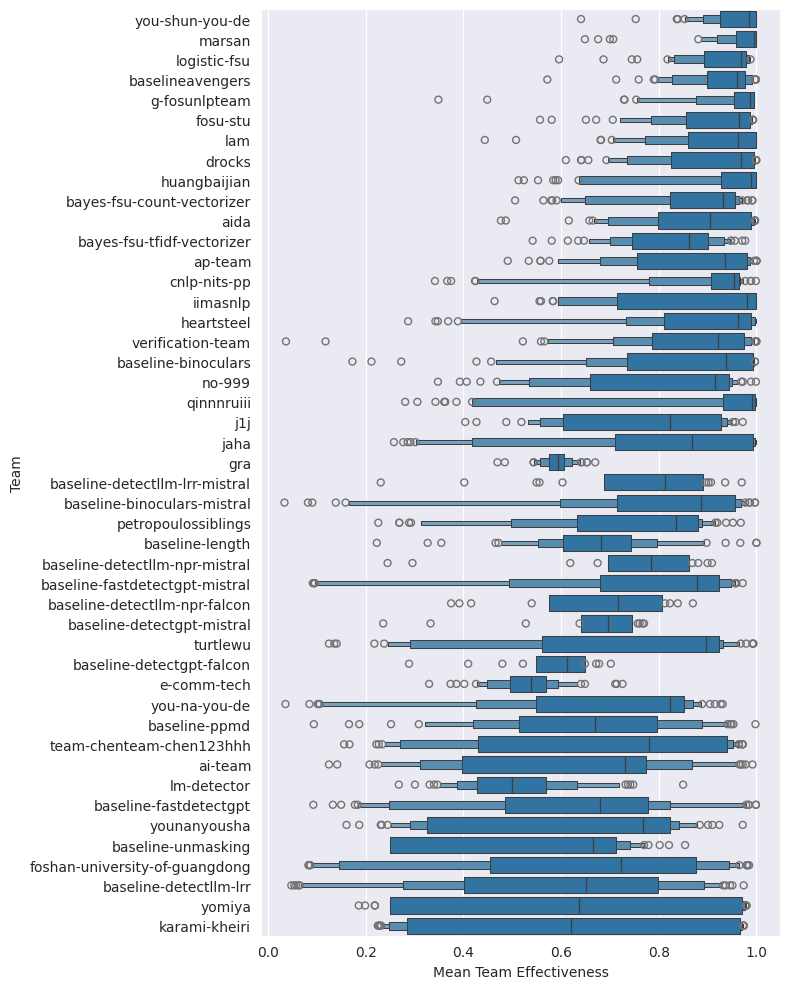

In [15]:
plt.figure(figsize=(8, 10))
sns.boxenplot(data=df, y='team', x='mean', order=df_system_mean_adjusted.reset_index()['team']).set(xlabel='Mean Team Effectiveness', ylabel='Team')
plt.tight_layout()
plt.savefig('../data/eval-figures/team-effectiveness.pdf')
plt.show()

### Dataset Difficulty

In [16]:
df_ds_mean = (1 - df).groupby('dataset').mean().sort_values('mean', ascending=False)
df_ds_mean.to_csv('../data/eval-figures/eloquent-effectiveness.csv')
df_ds_mean

,roc-auc,brier,c@1,f1,f05u,mean
dataset,,,,,,
bigscience-bloomz-7b1-short,0.403553,0.328026,0.455447,0.511342,0.503658,0.440368
text-bison-002-german-short,0.393895,0.328553,0.475289,0.493868,0.496579,0.437658
gpt-4-turbo-preview-german-short,0.399000,0.341947,0.467289,0.494526,0.475816,0.435684
vicgalle-gpt2-open-instruct-v1-short,0.342132,0.293053,0.412289,0.549237,0.573737,0.434053
alpaca-7b-short,0.324658,0.279474,0.399947,0.510158,0.545553,0.411921
...,...,...,...,...,...,...
meta-llama-llama-2-70b-chat-hf,0.089457,0.102022,0.107391,0.118457,0.115043,0.106500
mistralai-mistral-7b-instruct-v0.2-cross-domain,0.096600,0.105675,0.114500,0.109550,0.101000,0.105450
meta-llama-llama-2-70b-chat-hf-cross-domain,0.092450,0.100650,0.108925,0.113150,0.111000,0.105250


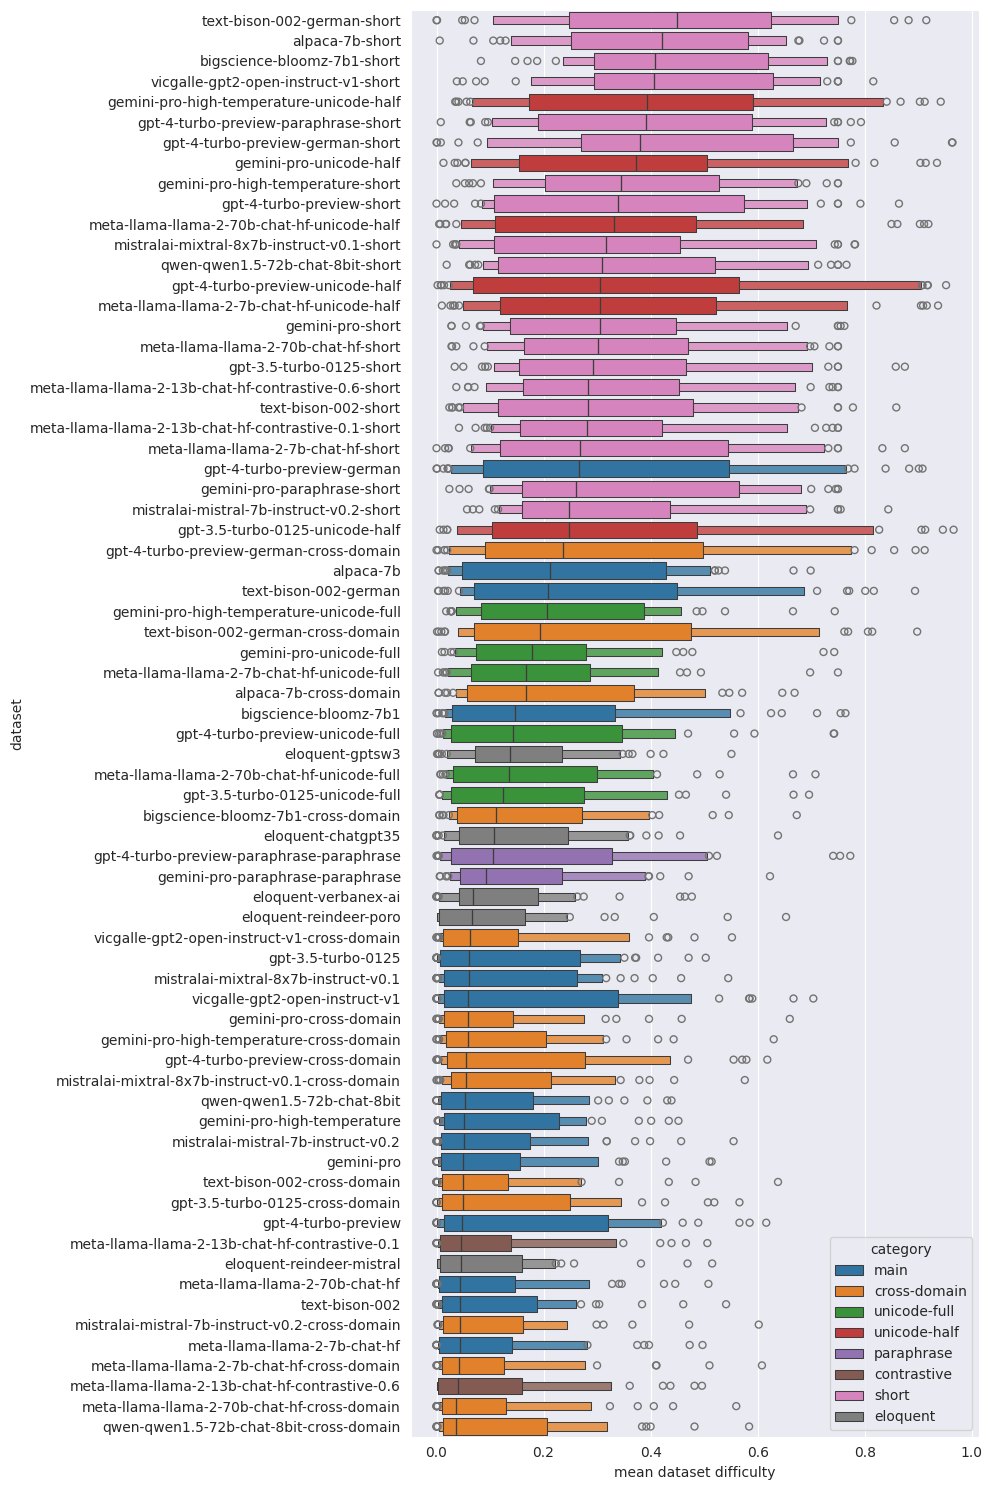

In [17]:
sort_order = df.groupby('dataset').median().sort_values('mean').index
plt.figure(figsize=(10, 15))
sns.boxenplot(data=(1 - df), y='dataset', x='mean', hue='category', order=sort_order).set(xlabel='mean dataset difficulty')
plt.tight_layout()
plt.savefig('../data/eval-figures/dataset-difficulty.pdf')
plt.show()

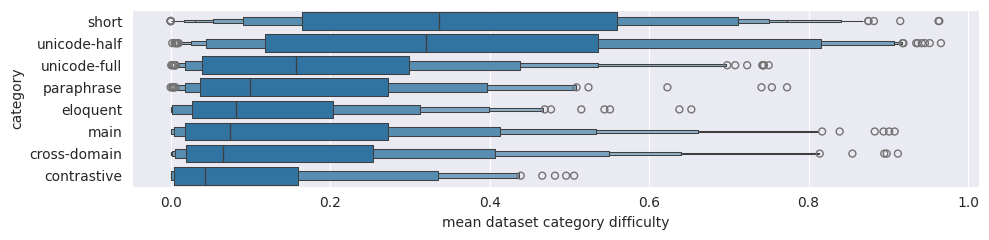

In [18]:
sort_order = df.groupby('category').median().sort_values('mean').index
plt.figure(figsize=(10, 2.5))
sns.boxenplot(data=(1 - df), y='category', x='mean', order=sort_order).set(xlabel='mean dataset category difficulty')
plt.tight_layout()
plt.savefig('../data/eval-figures/dataset-category-difficulty.pdf')
plt.show()

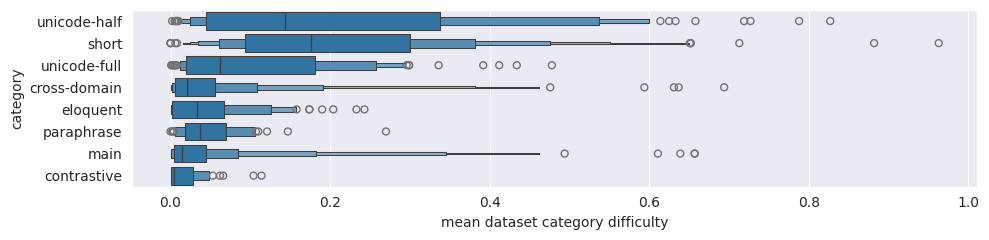

In [19]:
top_idx = df_system_mean_adjusted.iloc[:20].index
df_top = (1 - df).loc[top_idx.get_level_values(0), top_idx.get_level_values(1), :, :]
sort_order = df_top.groupby('category').mean().sort_values('mean', ascending=False).index

plt.figure(figsize=(10, 2.5))
sns.boxenplot(data=df_top, y='category', x='mean', order=sort_order).set(xlabel='mean dataset category difficulty')
plt.tight_layout()
plt.savefig('../data/eval-figures/dataset-category-difficulty-top.pdf')
plt.show()

### ELOQUENT Breaker Effectiveness

In [20]:
df_eloquent_ds = 1 - df.loc[:, :, 'eloquent']

df_eloquent = df_eloquent_ds.sort_values('mean', ascending=False)
df_eloquent.to_csv('../data/eval-figures/eloquent-effectiveness.csv')
df_eloquent

roc-auc  \
team                   system                 dataset                              
lm-detector            detector               eloquent-reindeer-poro       0.583   
baseline-detectllm-lrr baseline-detectllm-lrr eloquent-chatgpt35           0.629   
lm-detector            detector               eloquent-gptsw3              0.461   
e-comm-tech            great-plan             eloquent-reindeer-poro       0.476   
                                              eloquent-reindeer-mistral    0.465   
...                                                                          ...   
huangbaijian           bitter-metaphor        eloquent-verbanex-ai         0.000   
qinnnruiii             tender-couple          eloquent-reindeer-mistral    0.000   
                                              eloquent-reindeer-poro       0.000   
                                              eloquent-verbanex-ai         0.000   
heartsteel             canary-paint           eloquent-chatgpt35           0.000   

                                                                         brier  \
team                   system                 dataset                            
lm-detector            detector               eloquent-reindeer-poro     0.469   
baseline-detectllm-lrr baseline-detectllm-lrr eloquent-chatgpt35         0.356   
lm-detector            detector               eloquent-gptsw3            0.385   
e-comm-tech            great-plan             eloquent-reindeer-poro     0.323   
                                              eloquent-reindeer-mistral  0.314   
...                                                                        ...   
huangbaijian           bitter-metaphor        eloquent-verbanex-ai       0.000   
qinnnruiii             tender-couple          eloquent-reindeer-mistral  0.000   
                                              eloquent-reindeer-poro     0.000   
                                              eloquent-verbanex-ai       0.001   
heartsteel             canary-paint           eloquent-chatgpt35         0.000   

                                                                           c@1  \
team                   system                 dataset                            
lm-detector            detector               eloquent-reindeer-poro     0.656   
baseline-detectllm-lrr baseline-detectllm-lrr eloquent-chatgpt35         0.708   
lm-detector            detector               eloquent-gptsw3            0.542   
e-comm-tech            great-plan             eloquent-reindeer-poro     0.625   
                                              eloquent-reindeer-mistral  0.566   
...                                                                        ...   
huangbaijian           bitter-metaphor        eloquent-verbanex-ai       0.000   
qinnnruiii             tender-couple          eloquent-reindeer-mistral  0.000   
                                              eloquent-reindeer-poro     0.000   
                                              eloquent-verbanex-ai       0.000   
heartsteel             canary-paint           eloquent-chatgpt35         0.000   

                                                                            f1  \
team                   system                 dataset                            
lm-detector            detector               eloquent-reindeer-poro     0.789   
baseline-detectllm-lrr baseline-detectllm-lrr eloquent-chatgpt35         0.739   
lm-detector            detector               eloquent-gptsw3            0.714   
e-comm-tech            great-plan             eloquent-reindeer-poro     0.652   
                                              eloquent-reindeer-mistral  0.636   
...                                                                        ...   
huangbaijian           bitter-metaphor        eloquent-verbanex-ai       0.000   
qinnnruiii             tender-couple          eloquent-reindeer-mistral  0.000   
                          

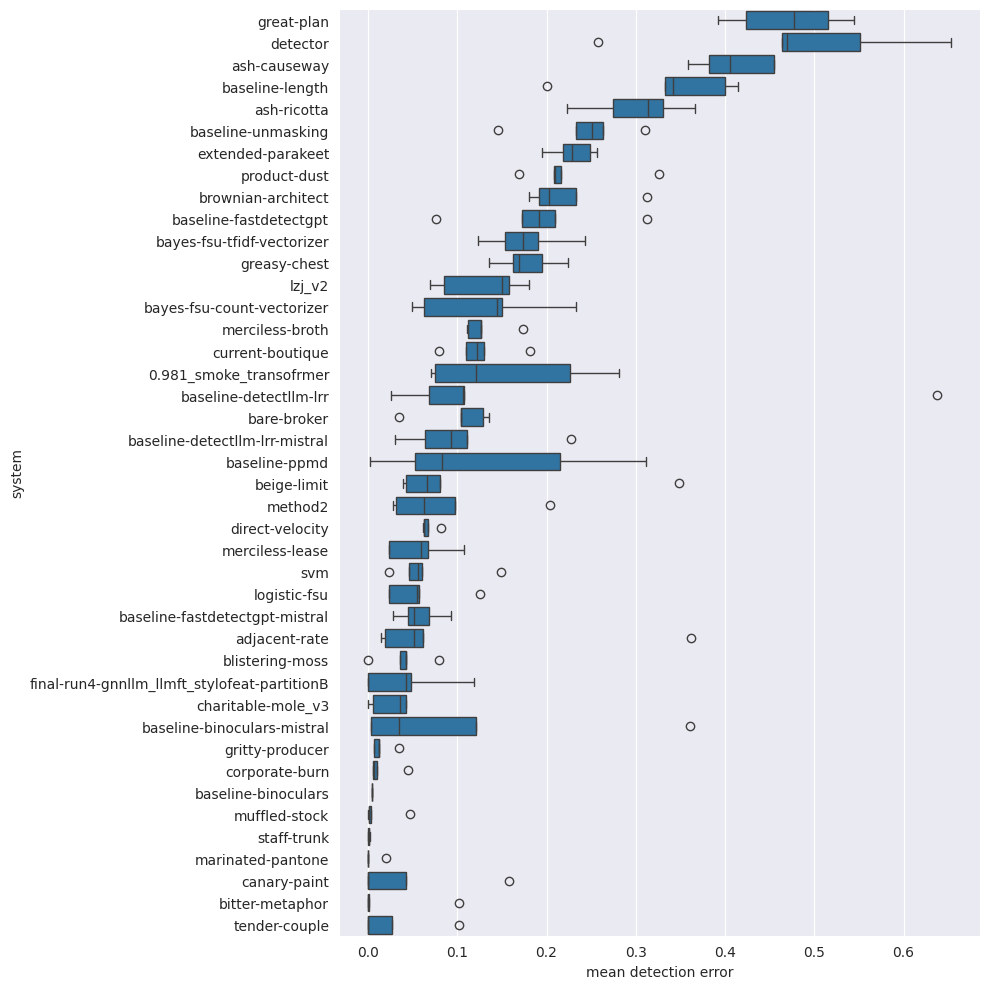

In [21]:
sort_order = df_eloquent_ds.groupby('system').median().sort_values('mean', ascending=False).index

plt.figure(figsize=(10, 10))
sns.boxplot(data=df_eloquent_ds, y='system', x='mean', order=sort_order).set(xlabel='mean detection error')
plt.tight_layout()
plt.savefig('../data/eval-figures/eloquent-system-effectiveness.pdf')
plt.show()

In [22]:
df_eloquent_mean = df_eloquent_ds.groupby('dataset').mean().sort_values('mean', ascending=False)
df_eloquent_mean.to_csv('../data/eval-figures/eloquent-effectiveness-mean.csv')
df_eloquent_mean

,roc-auc,brier,c@1,f1,f05u,mean
dataset,,,,,,
eloquent-gptsw3,0.149286,0.162571,0.179071,0.181929,0.159881,0.166548
eloquent-chatgpt35,0.129810,0.136810,0.161881,0.179857,0.192619,0.160214
eloquent-verbanex-ai,0.098429,0.119167,0.122929,0.142833,0.144667,0.125595
eloquent-reindeer-poro,0.100357,0.113310,0.117452,0.124905,0.126714,0.116571
eloquent-reindeer-mistral,0.084214,0.104405,0.103167,0.104381,0.100643,0.099357


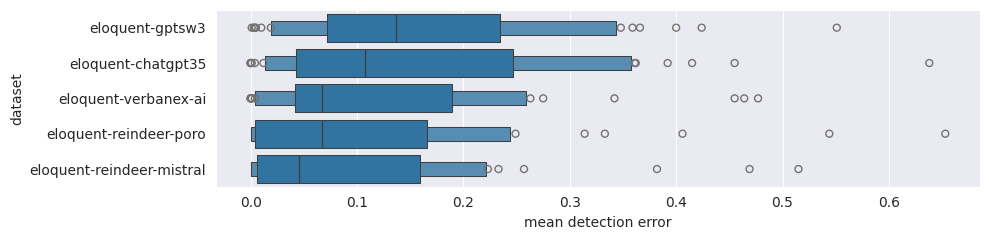

In [23]:
plt.figure(figsize=(10, 2.5))
sns.boxenplot(data=df_eloquent_ds, y='dataset', x='mean', order=df_eloquent_mean.index).set(xlabel='mean detection error')
plt.tight_layout()
plt.savefig('../data/eval-figures/eloquent-effectiveness.pdf')
plt.show()